<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/RNA/blob/main/Rede_neural_para_o_CILAMCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código com o objetivo de montar uma Rede Neural Artificial para formar um poliômio que relacione a densidade em função da pressão.

A arquitetura inicial é a seguinte:


*   Três entradas: Temperatura, Pressão e Salinidade;
*   Uma saída: Densidade.

Será realizado estudo da rede "perfeita", i.e., a rede com o menor erro relativo em função do número de camadas ocultas, número de neurônios ocultos, função de ativação e taxa de aprendizado.

A saber, as funções de ativação testadas serão:


1.   Sigmóide;
2.   Tangente Hipérbolica;
3.   Relu;
4.   LeakyRelu;

Com as seguintes taxas de aprendizado:



1.   0.01
2.   0.005
3.  0.001

Importando as bibliotecas necessárias

In [32]:
from keras.models import Sequential
from keras.layers import Dense
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import  MeanRelativeError
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros, Constant

tf.random.set_seed(231)

Definindo as funções e as taxas

In [2]:
funcoes = ['tanh', 'relu', 'sigmoid', 'LeakyReLU']
taxas = [0.005, 0.01, 0.05]

Função para definir o modelo e o treino do mesmo

In [3]:
def modelo_RNA(x, activation, nos, camadas_ocultas):
  modelo = Sequential()
  modelo.add(tf.keras.layers.Input(shape=(x.shape[1],)))
  #modelo.add(keras.layers.Dense(nos, activation='relu', input_shape=x.shape))
  for i in range(camadas_ocultas):
    modelo.add(keras.layers.Dense(nos, activation=activation, kernel_initializer=GlorotNormal()))
  modelo.add(keras.layers.Dense(1, activation= 'linear'))
  modelo.summary()

  return modelo

def padronizar_peso(modelo):
  for layer in modelo.layers:
    if isinstance(layer, Dense):
      weights, biases = layer.get_weights()
      weights_mean = weights.mean()
      weights_std = weights.std()
      weights = (weights - weights_mean) / weights_std
      layer.set_weights([weights, biases])
    return modelo

def treino_modelo(modelo, optimizer, loss, metrics, x_treino, y_treino, x_teste, y_teste, itr):
  modelo.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  resultado = modelo.fit(x_treino, y_treino, epochs=itr, batch_size=32, verbose = 1, validation_data=(x_teste, y_teste))

  return resultado, modelo

def erro_relativo(y_pred, y_true):
  return np.mean(np.abs((y_true - y_pred) / y_true))

In [4]:
def custo_final(resultado):
    train_loss = resultado.history['loss']
    val_loss = resultado.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'custo treino': train_loss[idx_min_val_loss], 'custo validação': val_loss[idx_min_val_loss]}

def plot_erro(resultado):
    treino_loss = resultado.history['loss']
    val_loss = resultado.history['val_loss']

    fig, ax = plt.subplots()
    ax.semilogy(treino_loss, label='Treino')
    ax.semilogy(val_loss, label='Validação')
    ax.set(title='Curvas de erro para o treino e a validação', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

Extraindo o dataset necessário

In [5]:
df = pd.read_excel('Densidade_temperatura_pressao_salinidade.xlsx')
df = df.drop('Densidade (kg/m3)', axis = 1)
#y = df['Densidade']
#x = df.drop('Densidade', axis = 1)

#proporção de treino e validação
prop_treino = 0.7 #70% treino
prop_valid = 0.15 #15% validação
prop_teste = 0.15 #15% teste

indices = np.arange(len(df))
treino, valteste = train_test_split(indices, train_size = prop_treino)
val, teste = train_test_split(valteste, test_size = prop_teste)

dados_treino = df.iloc[treino]
dados_validacao = df.iloc[val]
dados_teste = df.iloc[teste]

x_treino = dados_treino.drop('Densidade (g/cm3)', axis = 1); y_treino = dados_treino['Densidade (g/cm3)']
x_val = dados_validacao.drop('Densidade (g/cm3)', axis = 1); y_val = dados_validacao['Densidade (g/cm3)']
x_teste = dados_teste.drop('Densidade (g/cm3)', axis = 1); y_teste = dados_teste['Densidade (g/cm3)']

x_treino = x_treino.values ; x_val = x_val.values; x_teste = x_teste.values
y_treino = y_treino.values; y_val = y_val.values; y_teste = y_teste.values
#Normalizando
scaler = MinMaxScaler()
x_treino_normalizado = scaler.fit_transform(x_treino)
x_val_normalizado = scaler.transform(x_val)
x_teste_normalizado = scaler.transform(x_teste)


Para ver o melhor número de camadas ocultas e neuronios, é treinado com a função linear, assim:



*   Fixar o número de neuronios em 10;
*   Variar o número de camadas ocultos



In [6]:
erros = []
for i in range(2, 17):
  otimizador = tf.keras.optimizers.Adam(learning_rate = 0.01)
  nos = 10
  modelo = modelo_RNA(x_treino, 'linear', nos, i)
  modelo = padronizar_peso(modelo)

  resultado, modelo = treino_modelo(modelo, otimizador, 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 400)

  y_pred = modelo.predict(x_val)

  erro = mean_absolute_error(y_val, y_pred)
  erros.append((i, erro))

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 2/400
17/17 [==============================] - 0s 8ms/step - loss: 237.1552 - mae: 11.0401 - val_loss: 33.9056 - val_mae: 3.9817
Epoch 3/400
17/17 [==============================] - 0s 8ms/step - loss: 43.0919 - mae: 4.8866 - val_loss: 36.3037 - val_mae: 4.9240
Epoch 4/400
17/17 [==============================] - 0s 9ms/step - loss: 18.9548 - mae: 3.2629 - val_loss: 4.1167 - val_mae: 1.5142
Epoch 5/400
17/17 [==============================] - 0s 10ms/step - loss: 5.1105 - mae: 1.7111 - val_loss: 3.8695 - val_mae: 1.4611
Epoch 6/400
17/17 [==============================] - 0s 8ms/step - loss: 3.6772 - mae: 1.5169 - val_loss: 3.2266 - val_mae: 1.3458
Epoch 7/400
17/17 [==============================] - 0s 8ms/step - loss: 3.3243 - mae: 1.4269 - val_loss: 2.5652 - val_mae: 1.2346
Epoch 8/400
17/17 [==============================] - 0s 7ms/step - loss: 2.8473 - mae: 1.3581 - val_loss: 2.2801 - val_mae: 1.1764
Epoch 9/400
17/1

In [7]:
best_config = min(erros, key=lambda x: x[1])

print(f'Melhor configuração: {best_config[0]} camadas ocultas com erro relativo de {best_config[1]:.4f}')

Melhor configuração: 4 camadas ocultas com erro relativo de 0.0265


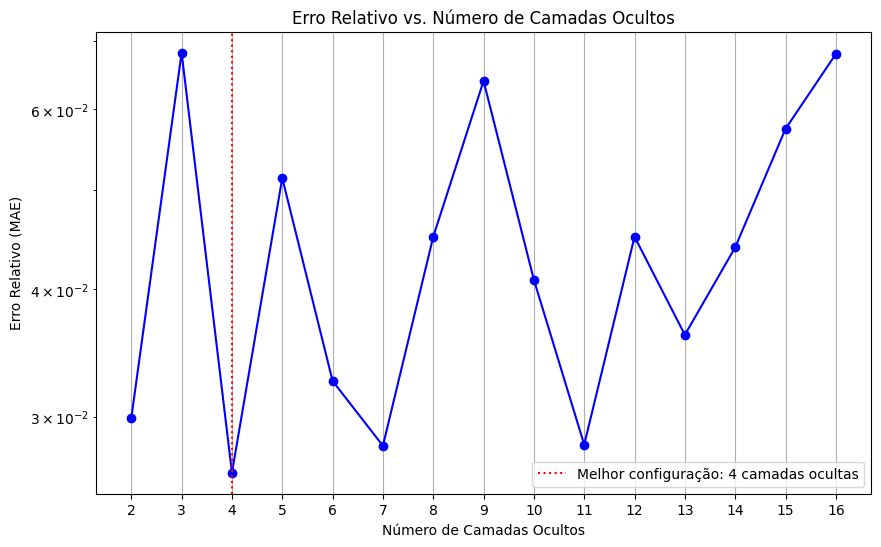

In [8]:
camadas, mae_errors = zip(*erros)
plt.figure(figsize=(10, 6))
plt.semilogy(camadas, mae_errors, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Camadas Ocultos')
plt.ylabel('Erro Relativo (MAE)')
plt.title('Erro Relativo vs. Número de Camadas Ocultos')
plt.grid(True)
plt.xticks(camadas)
plt.axvline(x=best_config[0], color='r', linestyle='dotted', label=f'Melhor configuração: {best_config[0]} camadas ocultas')
plt.legend()
plt.show()

Feito isso, o passo seguinte é variar o número de nós ocultas, fixando o número de camadas

In [9]:
erros_n = []
for i in range(10, 70, 5):
  otimizador = tf.keras.optimizers.Adam(learning_rate = 0.01)
  modelo = modelo_RNA(x_treino, 'linear', i, best_config[0])
  modelo = padronizar_peso(modelo)

  resultado, modelo = treino_modelo(modelo, otimizador, 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 400)

  y_pred = modelo.predict(x_val)

  erro = mean_absolute_error(y_val, y_pred)
  erros_n.append((i, erro))

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 362/400
17/17 [==============================] - 0s 8ms/step - loss: 0.0028 - mae: 0.0345 - val_loss: 0.0028 - val_mae: 0.0268
Epoch 363/400
17/17 [==============================] - 0s 7ms/step - loss: 0.0037 - mae: 0.0390 - val_loss: 0.0022 - val_mae: 0.0273
Epoch 364/400
17/17 [==============================] - 0s 7ms/step - loss: 0.0032 - mae: 0.0369 - val_loss: 0.0032 - val_mae: 0.0419
Epoch 365/400
17/17 [==============================] - 0s 7ms/step - loss: 0.0029 - mae: 0.0356 - val_loss: 0.0021 - val_mae: 0.0269
Epoch 366/400
17/17 [==============================] - 0s 7ms/step - loss: 0.0032 - mae: 0.0379 - val_loss: 0.0029 - val_mae: 0.0283
Epoch 367/400
17/17 [==============================] - 0s 7ms/step - loss: 0.0039 - mae: 0.0443 - val_loss: 0.0042 - val_mae: 0.0383
Epoch 368/400
17/17 [==============================] - 0s 7ms/step - loss: 0.0054 - mae: 0.0502 - val_loss: 0.0024 - val_mae: 0.0268
Epoch 369/

In [10]:
best_config_n = min(erros_n, key=lambda x: x[1])

print(f'Melhor configuração: {best_config_n[0]} nós ocultos com erro relativo de {best_config_n[1]:.4f}')

Melhor configuração: 15 nós ocultos com erro relativo de 0.0278


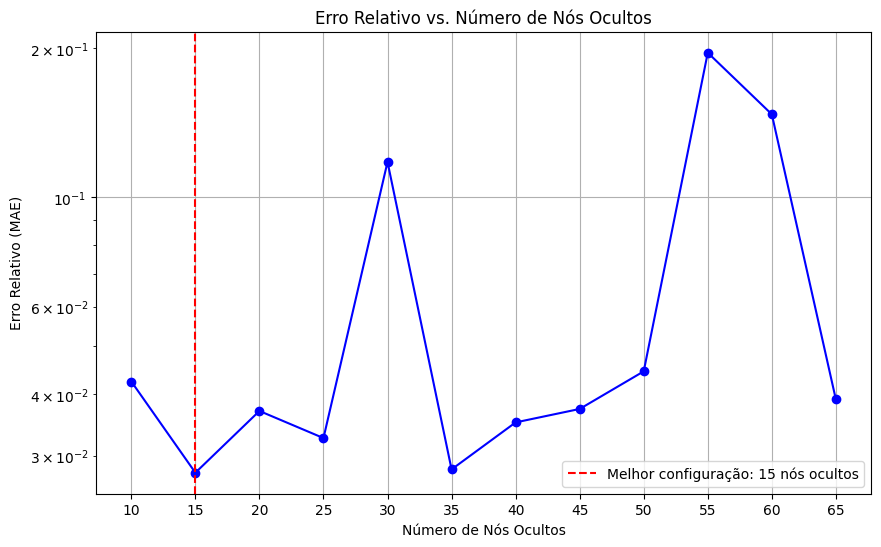

In [11]:
nos, mae_errors_n = zip(*erros_n)
plt.figure(figsize=(10, 6))
plt.semilogy(nos, mae_errors_n, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Nós Ocultos')
plt.ylabel('Erro Relativo (MAE)')
plt.title('Erro Relativo vs. Número de Nós Ocultos')
plt.grid(True)
plt.xticks(nos)
plt.axvline(x=best_config_n[0], color='r', linestyle='--', label=f'Melhor configuração: {best_config_n[0]} nós ocultos')
plt.legend()
plt.show()

Por fim, deve-se analisar a rede em função da função de ativação e da taxa de aprendizado

In [12]:
resultados = list()
erros_relativos = list()
for i in funcoes:
  #modelo = modelo_RNA(x_treino, i, 40, 11)
  for j in taxas:
      otimizador = tf.keras.optimizers.Adam(learning_rate=j)
      modelo = modelo_RNA(x_treino, i, best_config_n[0], best_config[0])
      modelo = padronizar_peso(modelo)

      resultado, modelo = treino_modelo(modelo, 'adam', 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 400)

      resultado = pd.DataFrame(resultado.history)
      resultados.append(resultado)

A saída de streaming foi truncada nas últimas 5000 linhas.
17/17 [==============================] - 0s 8ms/step - loss: 0.0029 - mae: 0.0383 - val_loss: 0.0024 - val_mae: 0.0345
Epoch 359/400
17/17 [==============================] - 0s 9ms/step - loss: 0.0030 - mae: 0.0385 - val_loss: 0.0024 - val_mae: 0.0351
Epoch 360/400
17/17 [==============================] - 0s 7ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0028 - val_mae: 0.0396
Epoch 361/400
17/17 [==============================] - 0s 8ms/step - loss: 0.0029 - mae: 0.0379 - val_loss: 0.0024 - val_mae: 0.0348
Epoch 362/400
17/17 [==============================] - 0s 8ms/step - loss: 0.0027 - mae: 0.0362 - val_loss: 0.0023 - val_mae: 0.0339
Epoch 363/400
17/17 [==============================] - 0s 7ms/step - loss: 0.0054 - mae: 0.0558 - val_loss: 0.0054 - val_mae: 0.0510
Epoch 364/400
17/17 [==============================] - 0s 8ms/step - loss: 0.0038 - mae: 0.0456 - val_loss: 0.0026 - val_mae: 0.0398
Epoch 365/400
17/17 [===

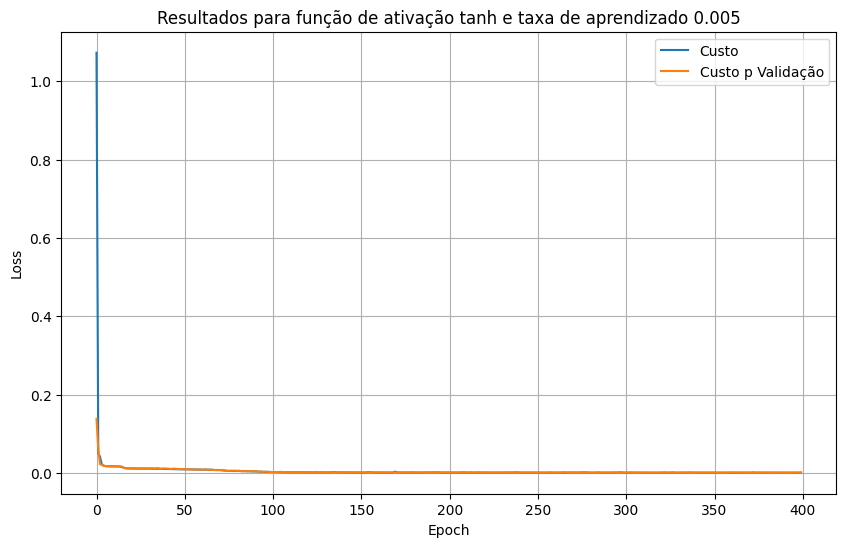

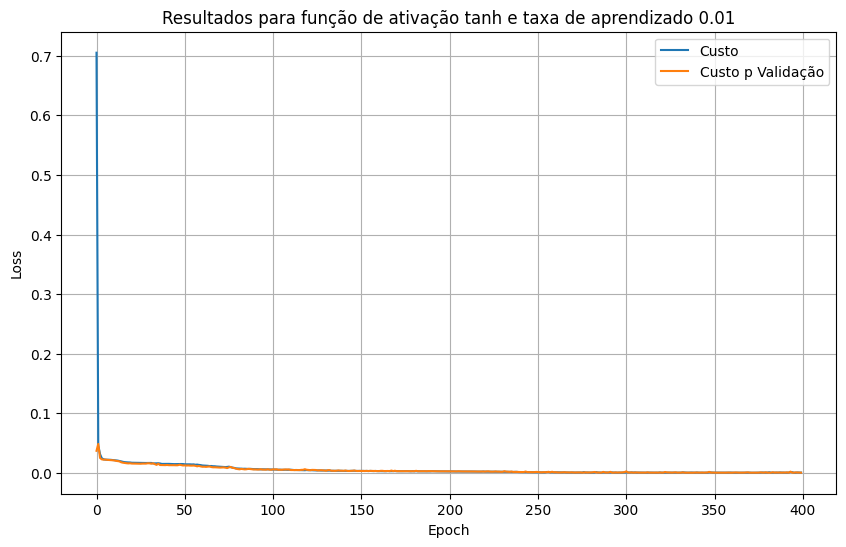

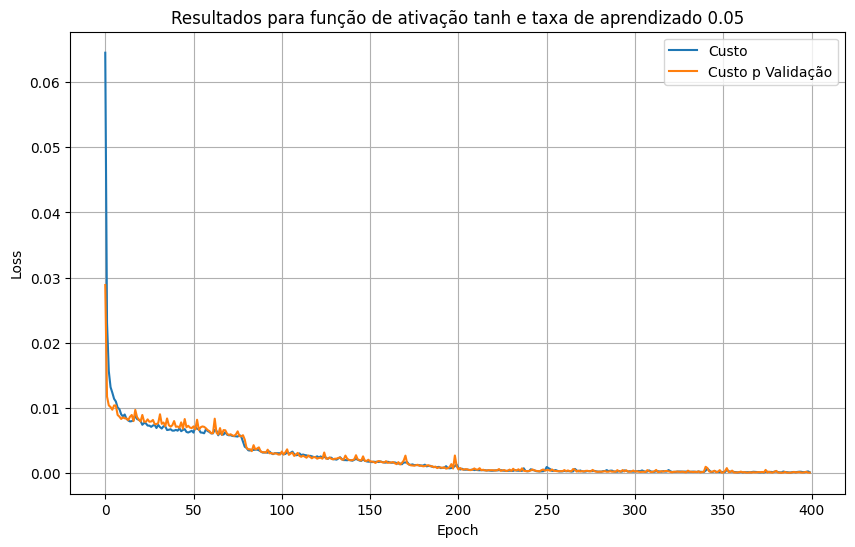

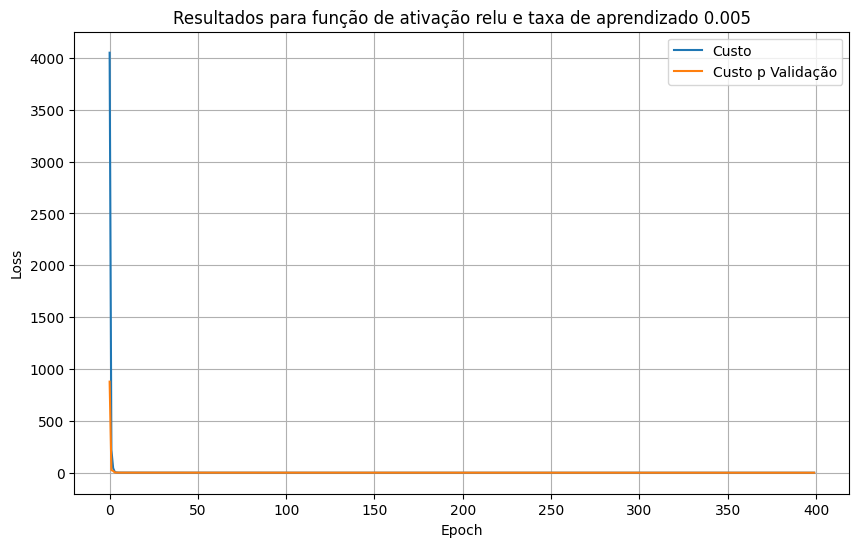

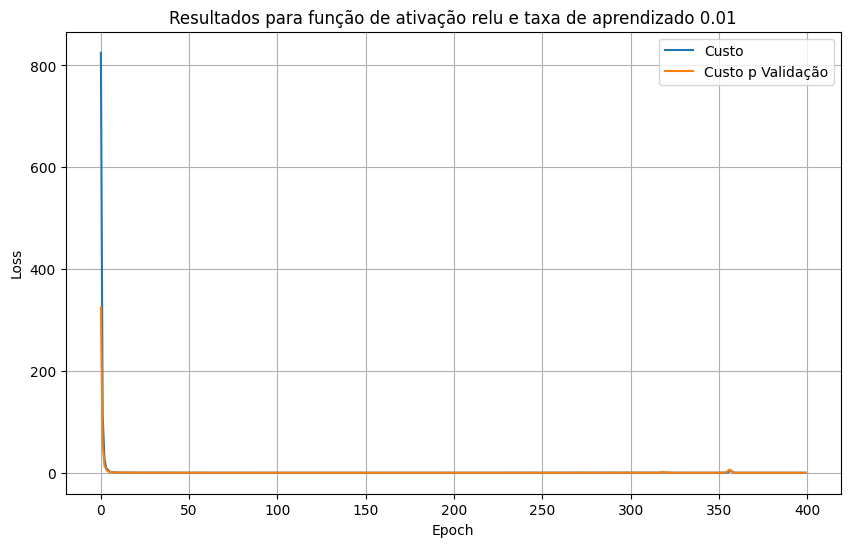

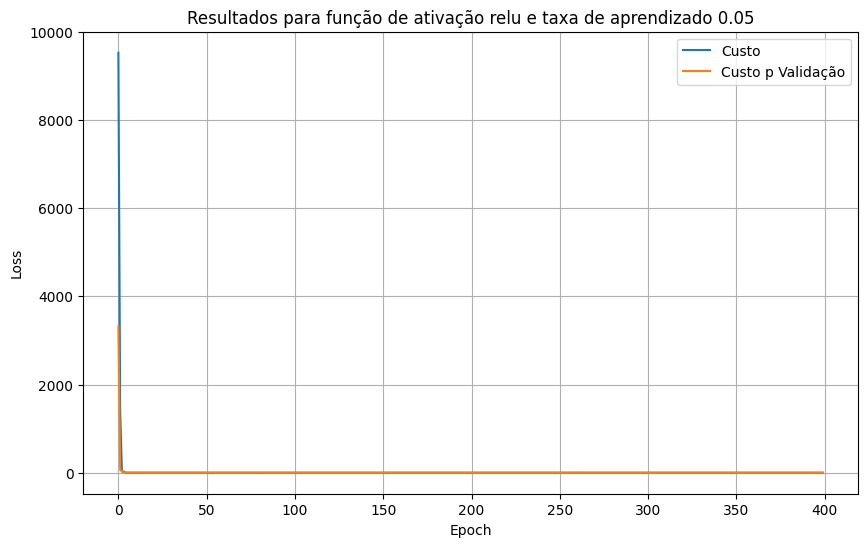

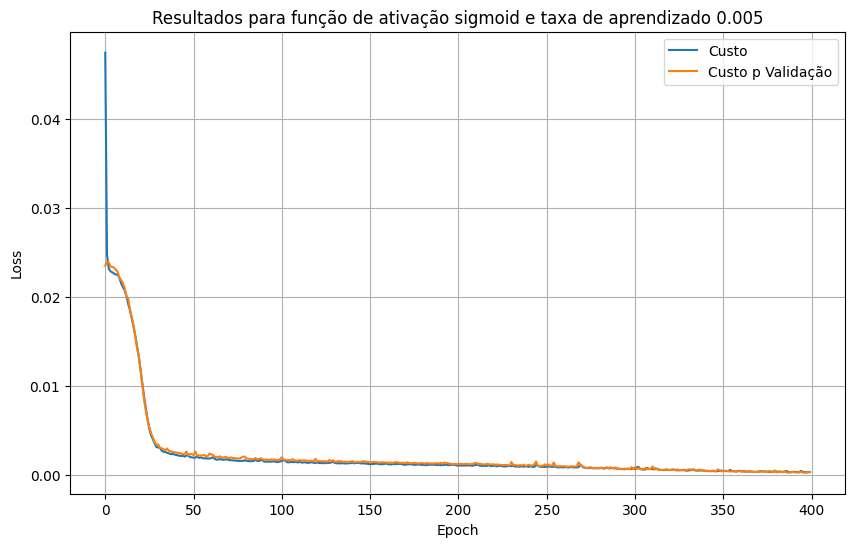

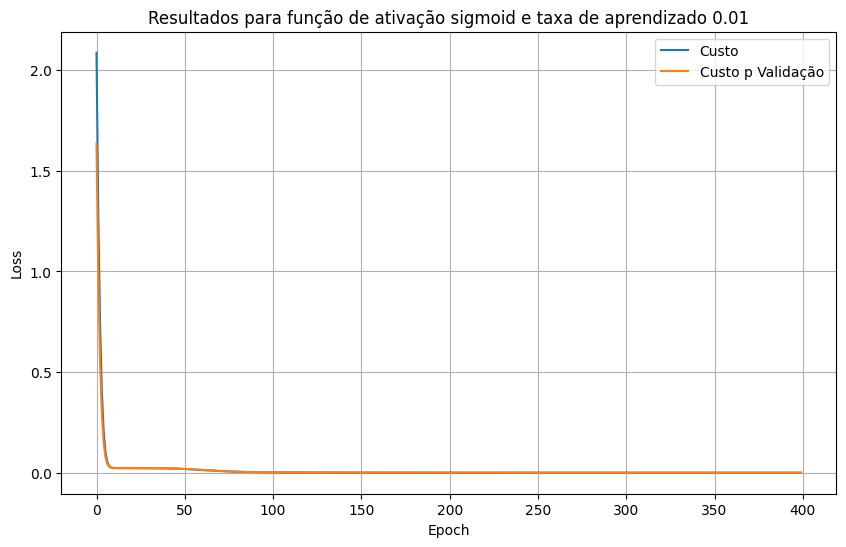

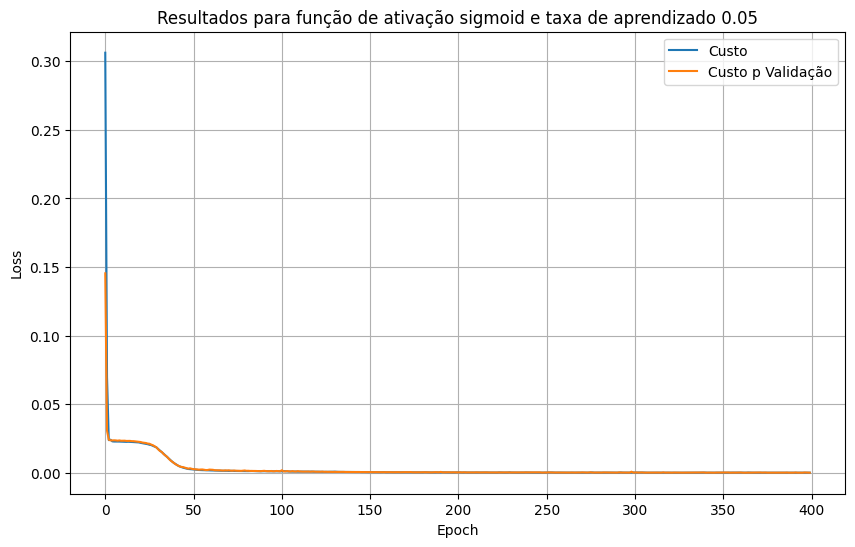

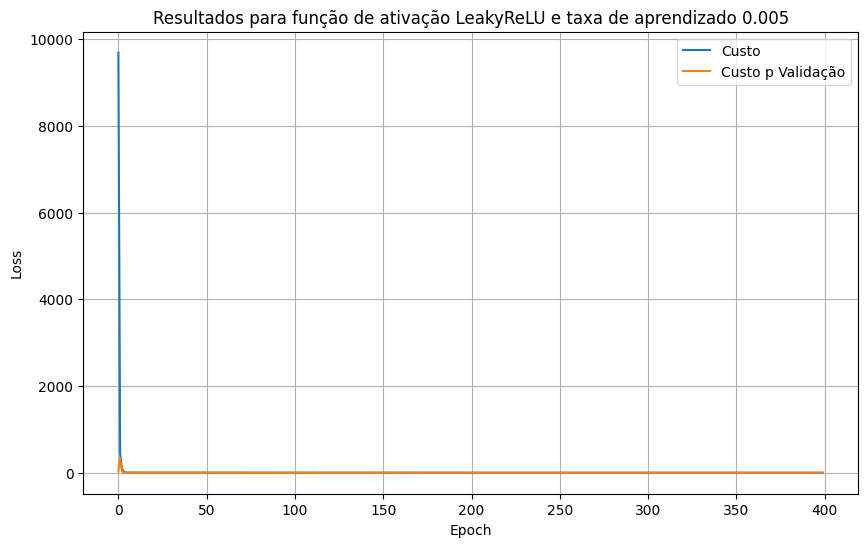

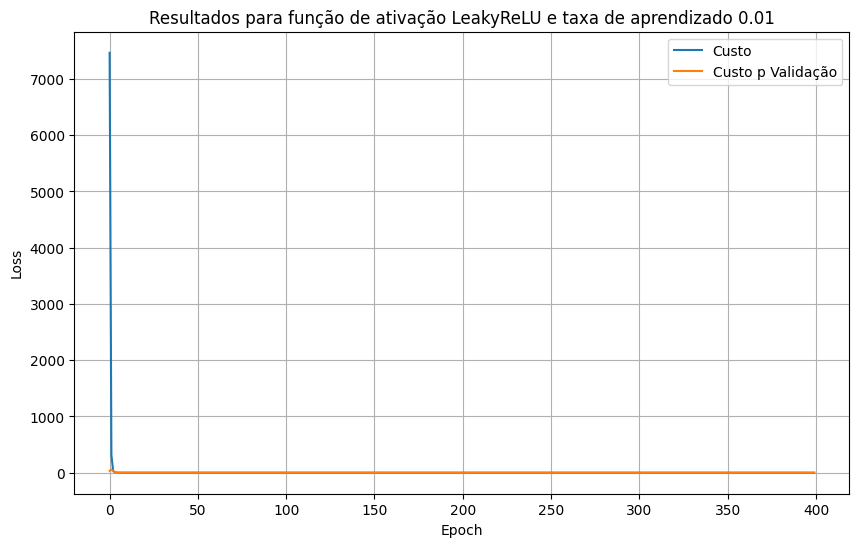

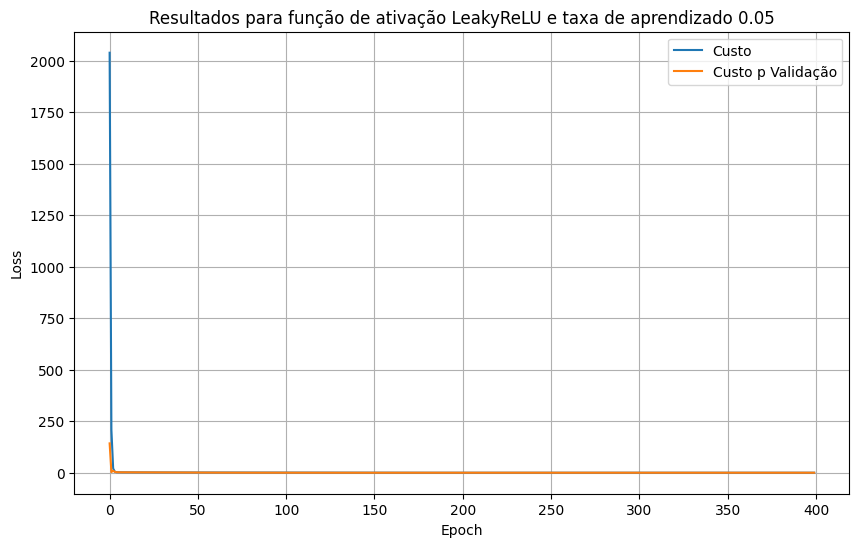

In [13]:
for i, funcao in enumerate(funcoes):
    for j, taxa in enumerate(taxas):
        resultado_df = resultados[i * len(taxas) + j]
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(resultado_df)), resultado_df['loss'], label='Custo')
        plt.plot(range(len(resultado_df)), resultado_df['val_loss'], label='Custo p Validação')
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Resultados para função de ativação {funcao} e taxa de aprendizado {taxa}')
        plt.legend()
        plt.show()

In [21]:
modelofinal = modelo_RNA(x_treino, 'tanh', best_config_n[0], best_config[0])

resultado, modelofinal = treino_modelo(modelofinal, 'adam', 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 330)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_275 (Dense)           (None, 15)                60        
                                                                 
 dense_276 (Dense)           (None, 15)                240       
                                                                 
 dense_277 (Dense)           (None, 15)                240       
                                                                 
 dense_278 (Dense)           (None, 15)                240       
                                                                 
 dense_279 (Dense)           (None, 1)                 16        
                                                                 
Total params: 796 (3.11 KB)
Trainable params: 796 (3.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/330
17/17 [====

In [22]:
modelofinal.get_weights()

[array([[-0.31362   , -0.26059204, -0.01470708, -0.02384547,  0.3200557 ,
          0.07132229, -0.30895406, -0.16455129, -0.12360905, -0.07917822,
         -0.11708812, -0.3147184 ,  0.08692725,  0.2463687 , -0.35622215],
        [ 0.6561928 , -0.03557186,  0.47882262, -0.0019917 , -0.35113037,
         -0.34593737, -0.4491466 , -0.3391738 ,  0.18037845,  0.43612292,
          0.00172191, -0.06672817, -0.3834349 ,  0.03813876,  0.43131045],
        [ 0.663671  , -0.12001687,  0.64654845, -0.28966698,  0.29462332,
         -0.12716058, -0.40335733, -0.54820955,  0.21443988,  0.28663388,
          0.0072049 ,  0.6945062 ,  0.24782336,  0.15661605, -0.39419916]],
       dtype=float32),
 array([ 0.09449758, -0.03254221,  0.07305118,  0.7291948 , -0.11092559,
        -0.07762243, -0.06759764, -0.0489184 ,  0.1422946 ,  0.06090078,
        -0.44265392, -0.0447215 , -0.07761724,  0.2538599 , -0.09477538],
       dtype=float32),
 array([[ 0.38409987, -0.31318372,  0.00241697,  0.29797462, -0.

In [23]:
modelofinal.save('modeloredeneuraldensidade.h5')

In [28]:
y_teste

array([0.921   , 0.99288 , 0.92021 , 0.97876 , 0.773   , 1.0011  ,
       1.03982 , 1.06572 , 1.13202 , 1.00115 , 0.983   , 0.99759 ,
       1.1913  , 0.82    , 1.028   , 1.08859 , 0.913   , 0.996   ,
       0.87    , 1.066   , 1.0299  , 1.136638, 0.948   , 0.799   ,
       0.84    , 0.91    , 0.9789  , 0.99809 , 0.93592 , 0.978   ,
       1.1047  , 1.1885  , 0.573   , 0.645   ])

In [29]:
u = modelofinal(x_teste)
u

<tf.Tensor: shape=(34, 1), dtype=float32, numpy=
array([[0.952984  ],
       [0.98064655],
       [0.9006589 ],
       [0.9694944 ],
       [0.7502753 ],
       [0.9867012 ],
       [1.0374    ],
       [1.0664421 ],
       [1.125208  ],
       [0.98723304],
       [0.98257333],
       [0.9849785 ],
       [1.1629332 ],
       [0.79751664],
       [1.0286771 ],
       [1.0773627 ],
       [0.90073663],
       [1.0352823 ],
       [0.88441324],
       [1.0664228 ],
       [1.0434095 ],
       [1.1282421 ],
       [0.9718995 ],
       [0.77299047],
       [0.81417555],
       [0.89917606],
       [0.9693694 ],
       [0.9888147 ],
       [0.9288161 ],
       [1.0009363 ],
       [1.1010818 ],
       [1.1618052 ],
       [0.6420122 ],
       [0.641577  ]], dtype=float32)>

In [35]:
mean_squared_error(y_teste, u)

0.0004307793122067521